In [1]:
import numpy as np
import warnings
import os
from datasets import load_dataset
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

/ext3/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1) Read in the data and create diagrams

To begin with, we are going to read in the 130 sentences stored in the dataset directory. Each senetence has been assigned as is standard in machine learning, these sentences are split into training, validation (dev), and development datasets.

In [4]:
def read_sst2(data_type="train"):
    dataset = load_dataset("sst2")

    data = dataset[data_type]

    usr_data = []
    usr_labels = []

    for example in data:
        usr_data.append(example["sentence"])
        usr_labels.append(example["label"])

    print("First sentence:", usr_data[0])
    print("First label:", usr_labels[0])

    return usr_data,usr_labels

train_data,train_labels = read_sst2("train")
dev_data,dev_labels = read_sst2("validation")
test_data,test_labels = read_sst2("test")

First sentence: hide new secretions from the parental units 
First label: 0
First sentence: it 's a charming and often affecting journey . 
First label: 1
First sentence: uneasy mishmash of styles and genres .
First label: -1


Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


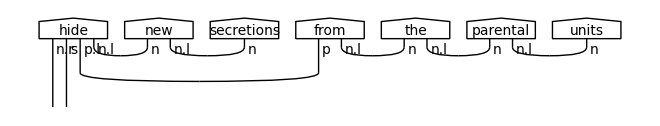

In [5]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data[:100])
raw_dev_diagrams = parser.sentences2diagrams(dev_data[:100])
raw_test_diagrams = parser.sentences2diagrams(test_data[:100])

raw_train_diagrams[0].draw()

Before removing cups


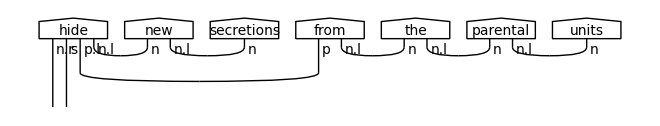

After removing cups


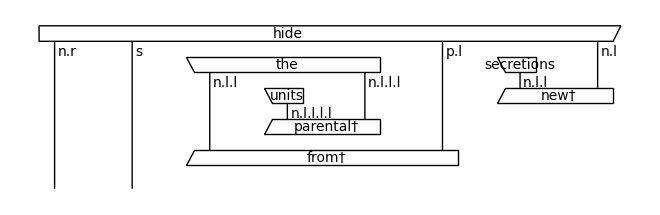

In [6]:
from lambeq import RemoveCupsRewriter

remove_cups = RemoveCupsRewriter()

print("Before removing cups")
raw_train_diagrams[0].draw()

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

print("After removing cups")
train_diagrams[0].draw()

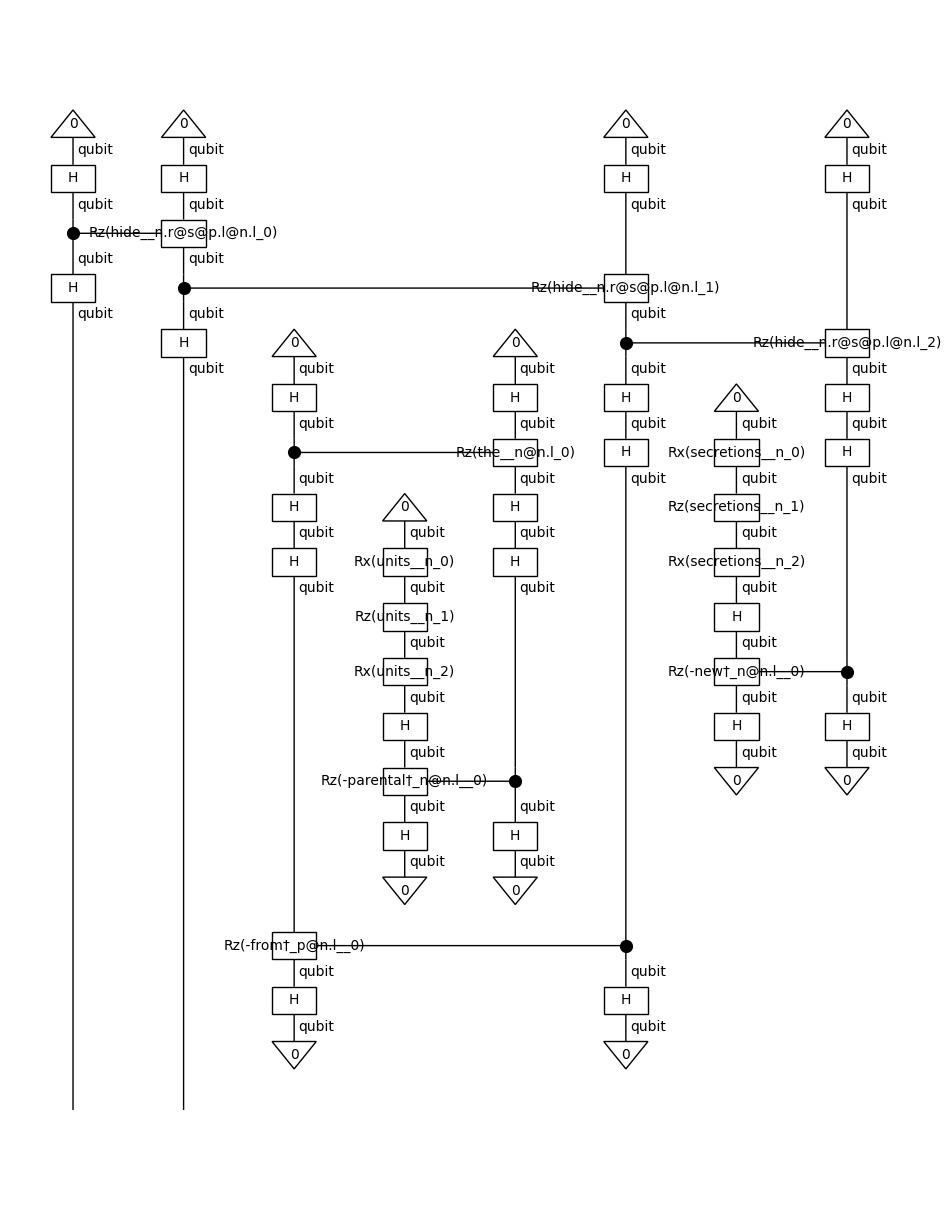

In [12]:
from lambeq import AtomicType, IQPAnsatz

# ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
#                    n_layers=1, n_single_qubit_params=3)
ansatz = IQPAnsatz({
    AtomicType.NOUN: 1,
    AtomicType.SENTENCE: 1,
    AtomicType.PUNCTUATION: 1,  # Add this if your diagrams include verbs
    AtomicType.PREPOSITIONAL_PHRASE: 1,  # Add this if your diagrams include adjectives
    AtomicType.NOUN_PHRASE: 1,
    AtomicType.CONJUNCTION: 1
}, n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(9, 12))

# Step 5: Choosing a backend
We are now going to choose a backend on which our quantum circuits is going to be run. In this workshop we are going to use a classical simulator (a classical computer which simulates the bahaviour of a real quantum computer) to run our circuits. 

In [13]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

all_circuits = train_circuits+dev_circuits+test_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

# Step 6: Creating the quantum sentence classifier. 

The code below trains our quantum sentence classifier. Since the training can take a few minutes we could alternatively work with a pre-trained model which you can load from the `checkpoint.pickle` file.

In [13]:
from lambeq import BinaryCrossEntropyLoss

model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

# loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
loss = BinaryCrossEntropyLoss()
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

from lambeq import QuantumTrainer, SPSAOptimizer

EPOCHS = 120
BATCH_SIZE = 30

trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False)
# trainer.fit(train_dataset, val_dataset, log_interval=1)

In [14]:
model = TketModel.from_checkpoint('classifier.pickle', backend_config=backend_config)
# model.save("classifier.pickle")

# Step 7: It's finally time for sentence generation!


We are now ready to implement an algorithm that generates a sentence about cooking. This will be achieved by searching through the space of all possible sentences in order to find and output a sentence about cooking. 

As discussed in the presentation the task above is called an optimisation problem. There are many different search strategies that can be employed to solve this task. Here we will employ the simplest possible strategy: Random guessing. 

Before we implement the random guessing algorithm we describe two helper functions. The details of how these are implemented are not important, but their input output behaviour is:

1. The `_create_sentence_searc_space()` function takes in no inputs and returns a list of all the sentences in our search space. 
2. The `_measure_quantum_circuit_for_sentence(sentence)` function takes in a sentence in the search space and measures the corresponding paraemterised quantum circuit, returning an array of two numbers between 0 and 1, which add up to 1. The first number represents the probability that the given sentence is about food, while the second number represents the probability that it is about IT.

In [15]:
from nltk import CFG
from nltk.parse.generate import generate

vocabulary = ['debugs', 'dinner', 'person', 'useful', 'runs', 'program', 'bakes', 'cooks', 'skillful', 'woman', 'prepares', 'application', 'man', 'software', 'sauce', 'meal', 'tasty']

subjects = ["man", "woman", "person"]
objects = ["sauce", "meal", "application", "software", "dinner", "program"]

def filter_sentence(sentence):
        # Make sure no word appears more than once:
        if not len(set(sentence)) == len(sentence):
            return False

        # Make sure subject appears before object:
        try:
            subject_position = next(i for i,v in enumerate(sentence) if v in subjects)
            object_position = next(i for i,v in enumerate(sentence) if v in objects)
        except:
            return False
        return subject_position < object_position

def _create_sentence_search_space():
    MC_GRAMMAR = """
      S -> NP VP
      NP -> N
      VP -> V NP
      NP -> A N
      A -> 'skillful' | 'tasty' | 'useful'
      N -> 'application' | 'dinner' | 'man' | 'meal' | 'person' | 'program' | 'sauce' | 'software' | 'woman'
      V -> 'bakes' | 'cooks' | 'debugs' | 'prepares' | 'runs'
      """

    GRAMMAR = CFG.fromstring(MC_GRAMMAR)
    SENTENCES = list(generate(GRAMMAR))

    SENTENCES = list(filter(filter_sentence, SENTENCES))
    return SENTENCES

def _measure_quantum_circuit_for_sentence(sentence):
    parser = BobcatParser(verbose='suppress')
    diagram = parser.sentences2diagrams([sentence])
    circ = [ansatz(remove_cups(d)) for d in diagram]

    return model.get_diagram_output(circ)[0]

### Generation assignment: Complete the  randomly_generate_sentence_with_topic function below. It's behaviour should be to continously guess a random sentence from the search space and then check to see if this is with high probability a sentence about the correct topic. If such a sentence is found, it should be returned. 

In [16]:
import random

sentences = _create_sentence_search_space()

def randomly_generate_sentence_with_topic(topic):
    i = 0
    while i < 100:
        i += 1
        print(i)
        sentence = " ".join(random.choice(sentences))
        print(sentence)
        prediction = _measure_quantum_circuit_for_sentence(sentence)
        print(prediction)
        if topic == "Food" and prediction[0] > 0.9:
            return i, sentence
            break
        elif topic == "IT" and prediction[1] > 0.9:
            return i, sentence
            break
    return 100, "Max iterations reached"

In [17]:
sentences[:10]

[['man', 'bakes', 'application'],
 ['man', 'bakes', 'dinner'],
 ['man', 'bakes', 'meal'],
 ['man', 'bakes', 'program'],
 ['man', 'bakes', 'sauce'],
 ['man', 'bakes', 'software'],
 ['man', 'bakes', 'skillful', 'application'],
 ['man', 'bakes', 'skillful', 'dinner'],
 ['man', 'bakes', 'skillful', 'meal'],
 ['man', 'bakes', 'skillful', 'program']]

Let's now run the function to generate a sentence about food

In [18]:
randomly_generate_sentence_with_topic("Food")

1
tasty person prepares useful meal
[0.80208333 0.19791667]
2
tasty woman debugs useful program
[0. 1.]
3
man prepares skillful sauce
[0.54411765 0.45588235]
4
skillful person runs tasty meal
[0.01276596 0.98723404]
5
useful person prepares program
[0.25 0.75]
6
useful person bakes software
[0.98449612 0.01550388]


(6, 'useful person bakes software')

# Bonus Question! (Difficult)
Of course, random guessing is not the most efficient way of navigating through the search space of sentences! 
In fact we already saw a cleverer way of performing this task in the presentation. This method was based on the well known hill climbing algorithm: https://en.wikipedia.org/wiki/Hill_climbing
Your task is to read about hill climbing and use your newfound knowledge to implement the sentence generation algorithm we covered in the presentation. 

In [19]:
def insert_word(sentence, vocabulary, test=False):
    """Inserts a random word from the vocabulary into a random position in the sentence."""
    sentence = sentence.split()
    position = random.randint(0, len(sentence))
    word = random.choice(vocabulary)
    new_sentence = sentence[:position] + [word] + sentence[position:]
    if test is True:
        return new_sentence
    elif filter_sentence(new_sentence):
        return new_sentence
    return sentence

def delete_word(sentence, test=False):
    sentence = sentence.split()
    if len(sentence) > 1:
        position = random.randint(0, len(sentence) - 1)
        new_sentence = sentence[:position] + sentence[position+1:]
        if test is True:
            return new_sentence
        elif filter_sentence(new_sentence):
            return new_sentence
    return sentence

def replace_word(sentence, vocabulary, test=False):
    """Replaces a word in the sentence with a random word from the vocabulary."""
    sentence = sentence.split()
    if len(sentence) > 0:
        position = random.randint(0, len(sentence) - 1)
        word = random.choice(vocabulary)
        new_sentence = sentence[:position] + [word] + sentence[position+1:]
        if test is True:
            return new_sentence
        elif filter_sentence(new_sentence):
            return new_sentence
    return sentence

# Generate a random sentence
random_sentence = " ".join(random.choice(sentences))

print("Original sentence: ", random_sentence)

modified_sentence = insert_word(random_sentence, vocabulary, test=True)
print("Insert word:", modified_sentence)

modified_sentence = delete_word(random_sentence, test=True)
print("Delete word:", modified_sentence)

modified_sentence = replace_word(random_sentence, vocabulary, test=True)
print("Replace word:", modified_sentence)

Original sentence:  tasty woman cooks dinner
Insert word: ['tasty', 'woman', 'meal', 'cooks', 'dinner']
Delete word: ['tasty', 'woman', 'dinner']
Replace word: ['tasty', 'tasty', 'cooks', 'dinner']


In [20]:
import math

def measure_score(sentence, topic):
    i=0
    score_sum=0
    while i<10:
        # print(i)
        new_score = _measure_quantum_circuit_for_sentence(sentence)
        if topic=="Food":
            score_sum += new_score[0]
        elif topic=="IT":
            score_sum += new_score[1]
        i+=1
    return score_sum/i

def simulated_annealing(current_sentence, topic, T=100, threshold=0.9):
    current_score = measure_score(current_sentence, topic)
    t=0
    print(current_score)
    print(current_sentence)
    
    while current_score <= threshold:    
        # Choose a random modification operation
        operation = random.choice([insert_word, delete_word, replace_word])
        new_sentence = " ".join(operation(current_sentence, vocabulary))
        # print(new_sentence)
        
        if new_sentence == current_sentence:
            continue
        try:
            new_score = measure_score(new_sentence, topic)
        except:
            # print("not within search space")
            continue
        
        # fast simulated annealing
        if new_score > current_score or random.random() < math.exp((new_score - current_score) / T):
            current_sentence = new_sentence
            current_score = new_score
        
        # Cool down
        T /= (t+1)
        t += 1
        print(current_score)
        print(current_sentence)
    
    return current_sentence

In [21]:
simulated_annealing(random_sentence, "IT")

0.4964705024558215
tasty woman cooks dinner
0.5104735809966189
woman cooks dinner
0.9993833667871999
woman dinner


'woman dinner'